In [1]:
import cv2 as cv
import numpy as np
import utilities
import matplotlib.pyplot as plt
import matplotlib.widgets as widg
import scipy as sp
import os

# 1. Getting keypoints via Scale-Invariant-Feature-Tranform(SIFT)

The goal here is to take the input image and run SIFT over it extracting keypoints and descriptors.
**SIFT** is feature extractor and descriptor algorithm. It utilizes several *Laplacian of Gaussian* (LoG) filters at multiple scales to detect blobs, edges and corners in the image. After detecting those features a descriptor is generated for all of them. SIFT descriptors encode the local intensity gradient environment surrounding a keypoint. Gradients within a certain pixel square around the keypoint are weighted and combined into a single 128 dimensional vector. The weights are chosen depending on the scale at which the keypoint was found, making the descriptors themselves invariant under scaling. Rotation invariance is achieved by constructing a local coordinate frame on top of the keypoint, taking into account the directions of the gradients. 


In [2]:
inputfile = "experiments/SrTiO3_1240.png"
path,fname, extension = utilities.get_filename_parts(inputfile)
try:
    os.mkdir(path+fname)
    path = path+fname+"/"
except FileExistsError:
    path = path+fname+"/"
    
img = cv.imread(inputfile)
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)

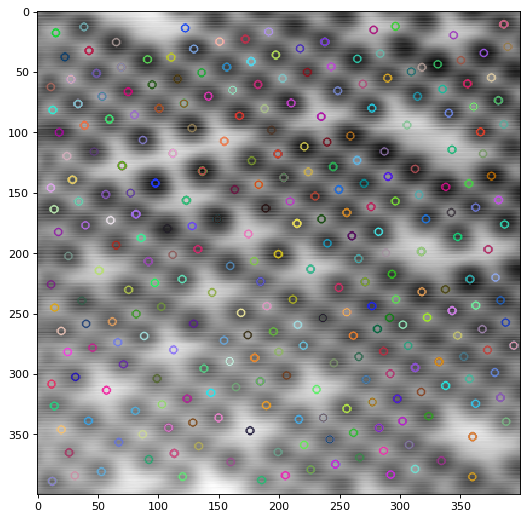

In [3]:
#This is really the main SIFT code:

#Feel free to play around with the parameters:
cThr = 0.00 #defaul: 0.01
sigma = 4#default: 3
nOctLayers = 5#efault: 3

sift = cv.xfeatures2d.SIFT_create(sigma = sigma, nOctaveLayers = nOctLayers)

#keypoints are detected and their angles set to 0 to distinguish differently oriented lattices:
kp = sift.detect(gray,None)
img_kp=cv.drawKeypoints(gray,kp,gray)

fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img_kp)
plt.show()

# 2. Clustering the keypoints based on their descriptors

Descriptors are then clustered using AgglomerativeClustering. The problem here is that we don't know the precise number of clusters we need. One method how to evaluate the quality of the clustering is to measure the **silhouette score** of the clustering, which measures simulaneously the self-similarity of each cluster and the difference between pairs of clusters. A good clustering yields a silhouette score of 1, whereas the worst possible score is -1.

We visualize the found clustering that maximizes this silhouette score by drawing colored dots on top of the image, where each color corresponds to one cluster of keypoints.

In [4]:
#Now compute descriptors

#!!!
#To break rotation invariance and compare keypoints that might have different local coordinate directions:
#set all these angles/directions to 0:
#!!
for i in range(np.size(kp)):
    kp[i].angle = 0
    
kp, des = sift.compute(gray,kp)

In [5]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

def find_best_clustering(descriptors,span = range(2,30),**kwargs):
    '''
    Finds the optimal number of clusters of the given descriptors
    wrt to the silhouette score
    
    Parameters:
    -----------
    descriptors - descriptors of some features, an nxd array for n features with d descriptors 
    span        - an iterable range of values, 
    **kwargs    - additional possible arguments for AgglomerativeClustering
    
    Result:
    -------
    best_labels - for each entry in descriptor returns a label specifying the described features cluster
    '''
    max_SC = 0
    labels = np.zeros(np.shape(descriptors)[0])
    for N in span:
        clustering = AgglomerativeClustering(n_clusters = N,**kwargs).fit(descriptors)
        labels = clustering.labels_
        sil_score = silhouette_score(descriptors,labels)
        if sil_score > max_SC:
            best_labels = labels
            max_SC = sil_score
    print("Maximal silhouette score found with {} clusters:\nsil_score = {}".format(max(set(best_labels)),max_SC))
    return best_labels

Maximal silhouette score found with 7 clusters:
sil_score = 0.18599720299243927

Below are all keypoints plotted, colored according to their label.
The size of the circle is the exact scale at which the keypoint was found,
and thus also shows which parts of the image are used for the descriptor


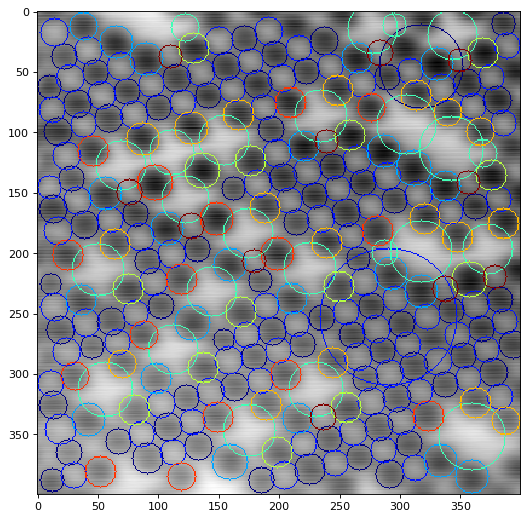

In [6]:
labels = find_best_clustering(des,span = range(2,9))

#visualize the found clusters 

print("\nBelow are all keypoints plotted, colored according to their label.\n\
The size of the circle is the exact scale at which the keypoint was found,\n\
and thus also shows which parts of the image are used for the descriptor")

fig=plt.figure(figsize=(8,8),dpi = 80, facecolor='w', edgecolor='k')
plot = utilities.plot_clusters(np.array(img),kp,labels)
plt.imshow(plot)
plt.savefig(path+"clustered_kps.png")
plt.show()


# 3.Extracting Lattice Vectors

Lattice vectors are defined to connect equivalent lattice sites. There are several challenges here that we have to overcome. 
 - There might be multiple sublattices of keypoints detected in the image which could mess up the calculation
 - Not all images will have quadratic unit cell, we want our method to still work on those types of lattices
 - The atoms in the image will never lie on their perfect lattice positions. There's always some amount of distortion in the image, and sometimes there might even be phonons captured in the image
 - There are some ambiguities in choosing the lattice vectors, we want the method to be predictable thus we have to make sure to always eliminate ambiguities
 - The clustering will not always be perfect and we don't want the method to break down because of one misclassified atom

So here's the method:<br>
Firstly, to eliminate all sublattices but one, we just focus on one keypoint cluster for now. To not end up with the cluster that describes all defects or other rare occurances in the image, we choose the cluster with the largest amount of keypoints:

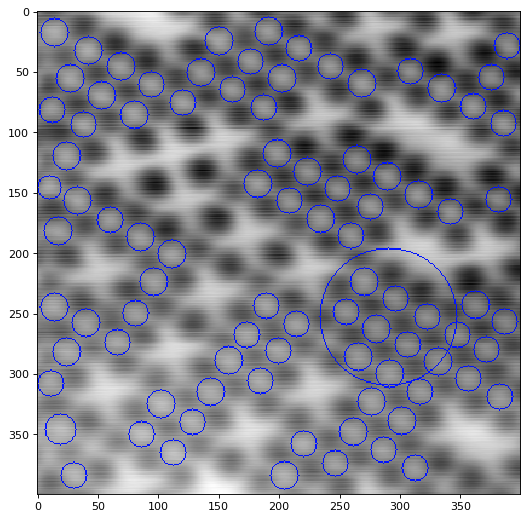

In [7]:
#cluster label with maximum number of keypoints:
l_max = np.argmax([np.size(labels[labels==i]) for i in set(labels)])

fig=plt.figure(figsize=(8,8),dpi = 80, facecolor='w', edgecolor='k')
plot2 = utilities.plot_one_cluster(np.array(img),kp,labels,l_max)
plt.imshow(plot2)
plt.show()

We can already see that we have a problem here. The keypoints with much larger size must happen to have quite similar descriptors to the other ones. Of course in this case we could easily filter out the "good" keypoints by setting a threshold on the size. However, mistakes like these will get made by the clustering, we can't rely on it and want to build a method that can deal with these sorts of things.<br>
If we focus on the regular circles, the primitive lattice vectors correspond to their first nearest neighbours. Let's calculate to first few nearest neighbours for all of these keypoints and view the resulting plot.

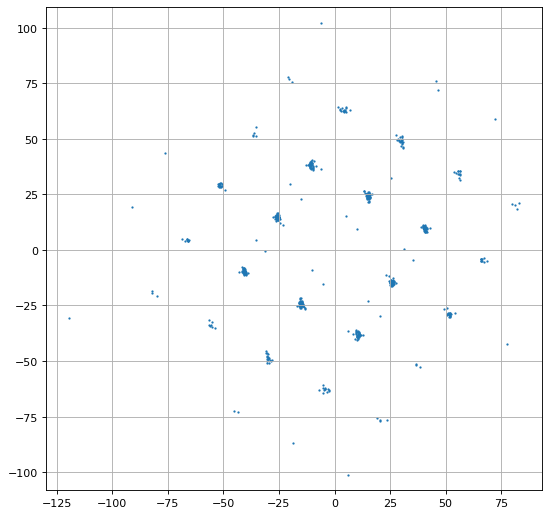

In [8]:
x = np.array([kp[i].pt for i in range(np.size(kp))])
x_ofMaxCluster = np.unique(x[labels==l_max,:],axis=0)
x = np.unique(x,axis=0)
k = 6
kNN = utilities.kNearestNeighbours(x_ofMaxCluster,k)

plt.figure(figsize=(8,8),dpi=80)
plt.axis("equal")
plt.grid()
plt.scatter(kNN[:,0],-kNN[:,1],s=1)
plt.show()

Above you can see peaks in density whenever many keypoints have similarly positioned neighbours. We also have some noise that comes from erroneously labeled keypoints.<br>
To extract the primitive lattice vectors we want to choose 2 linearly independent peaks with the least combined arc length. However, there will be a nearest neighbour at both +**a** and -**a** for any lattice vector **a**. To eliminate this ambiguity, we mirror all nearest Neighbours that lie in negative x direction through the origin.

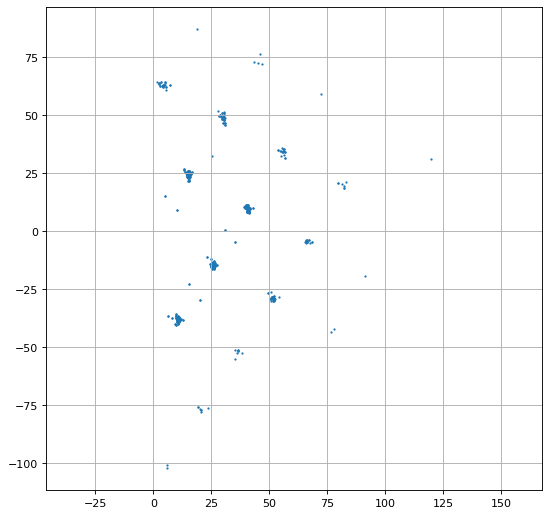

In [9]:
kNN_posX = np.array([-kNN[i,:] if kNN[i,0]<0 else kNN[i,:] for i in range(np.shape(kNN)[0])])

plt.figure(figsize=(8,8),dpi=80)
plt.axis("equal")
plt.grid()
plt.scatter(kNN_posX[:,0],-kNN_posX[:,1],s=1)#to relate the plot to the image, we have to mirror the x-axis
plt.show()

Now to get the peak positions we cluster the obtained unambiguous nearest Neighbours and calculate the average positions of each cluster. To get the right number of clusters (our clustering parameter) we can reuse find_best_clustering() from before.
To eliminate the small noisy clusters that might be placed near to the origin we will only consider peaks which have sufficiently many points around them.

In [10]:
print("Clustering NNV's of maximally represented feature class:")
kNN_labels = find_best_clustering(kNN_posX,span=range(k,3*k))

#the potential lattice vectors are the average vectors of each cluster:
average_peaks = np.array([np.average(kNN_posX[kNN_labels==l,:],axis=0) for l in set(kNN_labels)])

Clustering NNV's of maximally represented feature class:
Maximal silhouette score found with 16 clusters:
sil_score = 0.9040713066985125


In [11]:
#reduce these vectors further based on how big the found clusters are to prevent noise inflicted
#small clusters near the origin to mess with the result:
clustersizes = np.array([len(kNN_labels[kNN_labels==i]) for i in range(max(kNN_labels)+1)])
max_clustersize = np.max(clustersizes)
average_peaks = average_peaks[clustersizes>=max_clustersize/3,:]#!!!PARAMETER!!!!

#find primitive lattice vectors
sorted_ind = np.argsort(np.linalg.norm(average_peaks,axis=1))
average_peaks = np.take_along_axis(average_peaks,sorted_ind.repeat(2).reshape(np.shape(average_peaks)),axis = 0)
found = False
for i in range(np.shape(average_peaks)[0]):
    if found == True: break  
    for j in range(i+1,np.shape(average_peaks)[0]):
        if np.abs(np.cos(utilities.angle_between(average_peaks[i,:],average_peaks[j,:])))<0.95:
            a = average_peaks[i,:]
            b = average_peaks[j,:]
            found = True
            break

a = [ 14.86543393 -24.0468171 ]
b = [25.69506168 14.50785864]


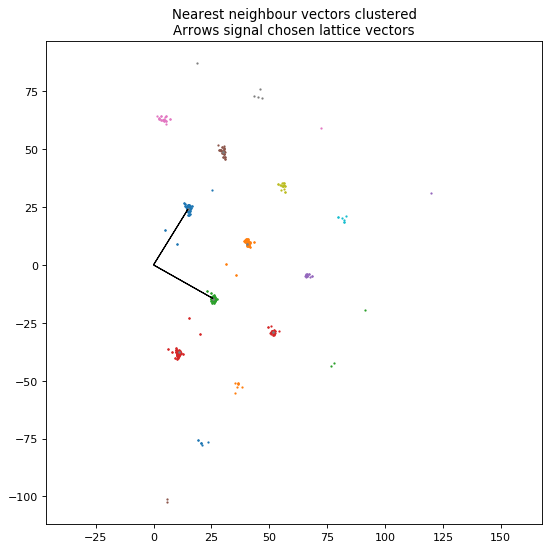

In [12]:
print("a = {}\nb = {}".format(a,b))

plt.figure(figsize=(8,8),dpi=80)
utilities.plot_clustered_NNVs(kNN_posX,kNN_labels,average_peaks,a,b)
plt.title("Nearest neighbour vectors clustered\nArrows signal chosen lattice vectors")
plt.savefig(path+"NNV_1cluster.png")
plt.show()

# 4. Finding Sublattice Positions

Having found the primitive lattice vectors, we can go back and look at all our original keypoints again. In crystallographie, a bravais lattice is always made up of a lattice (i.e. the primitive lattice vectors) and a basis (i.e. sublattice positions). For one chosen lattice, we want to know where the rest of the keypoints are positioned within this lattice.<br> 
This is now fairly straight forward to do. For any given keypoint we can look at its nearest lattice point and then transform it into that lattice points unit cell.

In [13]:
def sublattice_lookup(x,x_lat,a,b,SUBLplot = True):
    '''
    for each point x[i], search for nearest point x_lat[i]
    and fold x[i] into unit cell of x_lat[i] wrt to lattice vectors a and b 
    then cluster x's based on where they were folded to
    
    Parameters
    ----------
    
    Input:
    x - array(N,2) points to be grouped into sublattice positions
    x_lat - array(M,2) points that are known to lie on the lattice
    a,b - lattice vectors
    SUBLplot - boolean to decide wether or not to plot the sublattice positions
    
    Output:
    subl - center of masses (COM) of clusters in unit cell
    subl_labels - for each input x a label specifying the cluster it belongs to
    '''

    #To speed up the following nearest neighbour look ups
    #I arange the lattice points in a K-d-Tree
    tree = sp.spatial.KDTree(x_lat,leafsize=6)

    #lattice position of remaining x's when folded in the chosen unit cell:
    x_fd = np.zeros(np.shape(x))
    for i in range(np.shape(x)[0]):
        #look up the nearest lattice point which isn't itself:
        d,j = tree.query(x[i,:],k=6)
        j = j[d>0.001]
        x_fd[i,:] = np.linalg.solve(np.array([a,b]).T,x[i,:]-x_lat[j[0],:])%1

    print("calculating distance matrix of folded back points ...")
    d_matrix = sp.spatial.distance.cdist(x_fd,x_fd,dist_per)#dist_per is a distance function in 1x1 box with PBC
    print("done")

    print("Clustering keypoints based on their position in the lattice that has been found (i.e. find sublattices):")
    subl_labels = find_best_clustering(d_matrix,span=range(2,10),affinity="precomputed",linkage="average")

    subl = np.array([ COM(x_fd[subl_labels == i,:]) for i in set(subl_labels)])

    if SUBLplot:
        plt.figure(figsize=(8,8),dpi=80)
        plt.axis("equal")
        plt.title("Sublattice positions")
        for i in set(subl_labels):
            plt.scatter(x_fd[subl_labels == i,0],x_fd[subl_labels == i,1],label = i)
        plt.legend()
        plt.scatter(subl[:,0],subl[:,1])
        plt.savefig(path+"sublattice_positions.png")
        plt.show()
       
    return subl,subl_labels

def dist_per(u,v):
    '''
    function that calculates distances in a 1x1 unit cell with periodic boundary
    conditions
    '''
    deltax = np.abs(u-v)
    d = np.sqrt(\
            np.sum(\
                np.amin(\
                    np.array([deltax,1-deltax])\
                    ,axis=0)**2\
            )\
        )
    return d

def COM(x):
    '''
    calculating the average position of each cluster (Center Of Mass)
    following COM calculation by Linge Bai and David Breen:
    "Calculating Center of Mass in an Unbounded 2D environment"
    '''
    N,k = np.shape(x)
    COM = np.zeros(2)
    ri = 1/(2*np.pi)
    #first component:
    theta_i = x[:,0]*2*np.pi
    x1 = np.zeros((N,3))
    x1[:,0] = ri*np.cos(theta_i)
    x1[:,1] = x[:,1]
    x1[:,2] = ri*np.sin(theta_i)
    X_bar = np.average(x1,axis=0)
    if np.abs(X_bar[0]) >= 0.001 and np.abs(X_bar[2])>=0.001:
        theta = np.arctan2(-X_bar[2],-X_bar[0])+np.pi
    else:
        theta = 0
    COM[0] = ri*theta
    #second component:
    theta_i = x[:,1]/ri
    x1[:,0] = x[:,0]
    x1[:,1] = ri*np.cos(theta_i)
    x1[:,2] = ri*np.sin(theta_i)
    X_bar = np.average(x1,axis=0)
    if np.abs(X_bar[0]) >= 0.001 and np.abs(X_bar[2])>=0.001:
        theta = np.arctan2(-X_bar[2],-X_bar[1])+np.pi
    else:
        theta = 0
    COM[1] = ri*theta
    return COM

calculating distance matrix of folded back points ...
done
Clustering keypoints based on their position in the lattice that has been found (i.e. find sublattices):
Maximal silhouette score found with 1 clusters:
sil_score = 0.8895193757902252


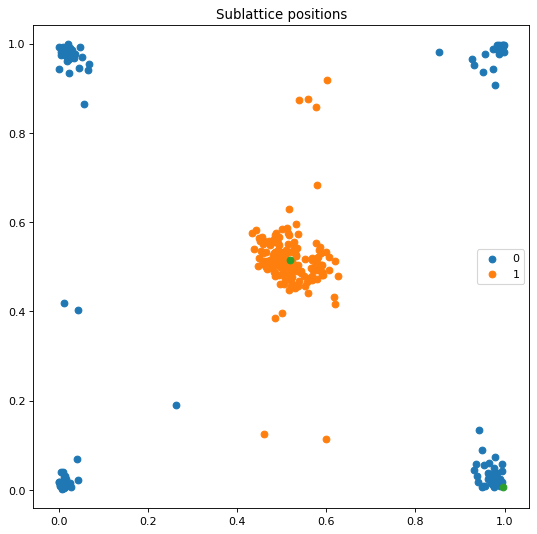

sublattice positions:
[[0.99584776 0.00592493]
 [0.51836524 0.51460586]]


In [14]:
subl, subl_labels = sublattice_lookup(x,x_ofMaxCluster,a,b,SUBLplot = True)
print("sublattice positions:\n{}".format(subl))

# 5. Going beyond periodicity

Having extracted the necessary bits of a periodic lattice, we can now go beyond and also focus on deviations from this periodicity.

Just as an example, we can plot all 1st nearest neighbours for each sublattice and color them according to their difference from the average lattice vector.

In [15]:
def plot_lattice_deviations(x,a,b,subl_labels,k=20,rtol_ini = 2,sizes = 10):
    '''
    As a final result plot the kNN-vectors from their respective keypoint,
    colored by how much they deviate from the found lattice vectors
    '''
    x = np.unique(x,axis=0)
    kNN = utilities.kNearestNeighbours(x,k)
    #append the basis vectors to see which cluster they get mapped to
    kNN = np.append(kNN,[a,b]).reshape(np.shape(x)[0]*k+2,2)
    kNN_right = np.array([kNN[i,:] if kNN[i,0]>=0 else -kNN[i,:] for i in range(np.shape(kNN)[0])])

    rtol = rtol_ini
    while True:
        kNN_red,kNN_labels = utilities.DensityClustering(kNN_right,rtol = rtol)

        plt.figure(figsize=(8,8),dpi=80)
        plt.axis("equal")
        for i in set(kNN_labels):
            plt.scatter(kNN_right[kNN_labels==i,0],-kNN_right[kNN_labels==i,1],s=sizes)
        plt.scatter(kNN_red[:,0],-kNN_red[:,1],label = "reduced",s=sizes*4)
        plt.arrow(0,0,a[0],-a[1])
        plt.arrow(0,0,b[0],-b[1])
        plt.title("Nearest Neighbour vectors clustered and reduced, rtol={}\nThis time for all keypoints".format(rtol))
        plt.show()
        if utilities.yes_or_no("Change rtol?"):
            rtol = float(input("rtol = \n"))
        else:
            break

    for s in set(subl_labels):
        #I want to plot the NN-vectors for each sublattice
        #for that I need proper masks to seperate the sublattices out of x and kNN
        isinSubl = subl_labels == s
        kNNofSubl = isinSubl.repeat(k)
        kNNofSubl = np.append(kNNofSubl, [False,False])

        plt.figure(s,figsize=(8,8),dpi=80)
        plt.imshow(gray,cmap = "Greys_r")
        #plot all NN-vectors that belong to the first basis vector:
        is_a = kNN_labels==kNN_labels[-2]
        is_a[-2:] = [False]*2
        kp_inds1 = np.where(is_a & kNNofSubl)[0]//k
        kps1 = np.take(x,kp_inds1,axis=0)
        diff = np.linalg.norm(kNN_right[is_a & kNNofSubl,:]-a,axis = 1)
        #diff = diff/np.max(diff)
        #diff[diff>8] = 8
        quiv1 = plt.quiver(kps1[:,0],kps1[:,1],kNN[is_a & kNNofSubl,0],kNN[is_a & kNNofSubl,1],diff,cmap = "plasma",scale_units="xy",angles="xy",scale=1)

        #second basis vector:
        is_b = kNN_labels==kNN_labels[-1]
        is_b[-2:] = [False]*2
        kp_inds1 = np.where(is_b & kNNofSubl)[0]//k
        kps1 = np.take(x,kp_inds1,axis=0)
        diff = np.linalg.norm(kNN_right[is_b & kNNofSubl,:]-b,axis = 1)
        #diff = diff/np.max(diff)
        #diff[diff>8] = 8
        quiv1 = plt.quiver(kps1[:,0],kps1[:,1],kNN[is_b & kNNofSubl,0],kNN[is_b & kNNofSubl,1],diff,cmap = "plasma",scale_units="xy",angles="xy",scale=1)
        cbar = plt.colorbar()
        cbar.ax.set_ylabel("deviation from average lattice vectors")
        plt.title("Deviation of NN-vectors from average lattice vector\nsublattice {}".format(s))
        plt.savefig(path+"deviations{}".format(s))
        plt.show()

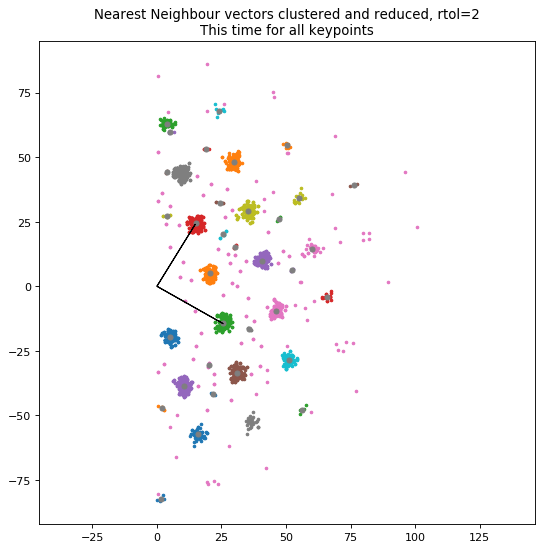

Change rtol? (y/n) n


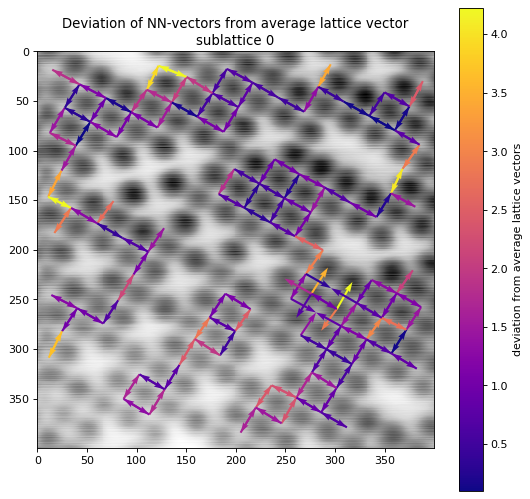

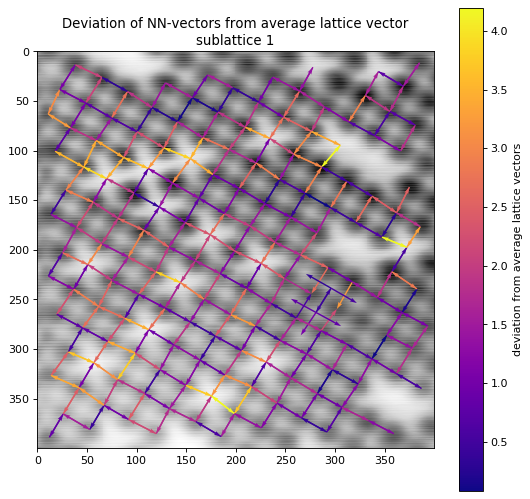

In [16]:
plot_lattice_deviations(x,a,b,subl_labels,k=15,rtol_ini = 2,sizes = 5)